<a href="https://colab.research.google.com/github/ShivaKondapalli/AILearning/blob/master/Download_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we get a list of urls from the web, these urls contain links to our images on the web. 

In [0]:

from fastai import *
from fastai.vision import *

In [4]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   2360      0 --:--:-- --:--:-- --:--:--  2360
Updating fastai...
Done.


Head to [google images](https://images.google.com/?gws_rd=ssl) and search images of your choice.  Then, after scrolling down till we hit "Show more results", we shall write some JavaScript code to save all the URLS of these images. It is as follows 




```javascript
 urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

```







In [0]:
folder = 'badminton'
file = 'badminton_urls.txt'

In [0]:
path = Path('data/rackets')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
download_images(path/file, dest, max_pics=200)

In [0]:
folder='tennis'
file = 'tennis_urls.txt'

In [0]:
path = Path('data/rackets')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
download_images(path/file, dest, max_pics=200)

In [0]:
folder='squash'
file='squash_urls.txt'

In [0]:
path= Path('data/rackets')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [13]:
path.ls()

[PosixPath('data/rackets/badminton_urls.txt'),
 PosixPath('data/rackets/tennis'),
 PosixPath('data/rackets/models'),
 PosixPath('data/rackets/squash_urls.txt'),
 PosixPath('data/rackets/squash'),
 PosixPath('data/rackets/tennis_urls.txt'),
 PosixPath('data/rackets/badminton')]

In [0]:
download_images(path/file, dest, max_pics=200)

In [0]:
classes = ['badminton', 'squash', 'tennis']

In [16]:
help(verify_images)

Help on function verify_images in module fastai.vision.data:

verify_images(path:Union[pathlib.Path, str], delete:bool=True, max_workers:int=4, max_size:int=None, recurse:bool=False, dest:Union[pathlib.Path, str]='.', n_channels:int=3, interp=2, ext:str=None, img_format:str=None, resume:bool=None, **kwargs)
    Check if the images in `path` aren't broken, maybe resize them and copy it in `dest`.



Now that we have all the images and the classes, we must loop through these folders to find out those images which are not opening. Then we delete these images by setting the keyword argumnet delete= True.

In [0]:
# use verify_images() function which will see if a image is correct or not
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_workers=8)

Now that we have folders with classnames and data belonging to those classes on their respective folders, we can use ImageDataBunch() class and feed it path. 

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [19]:
data.classes

['badminton', 'squash', 'tennis']

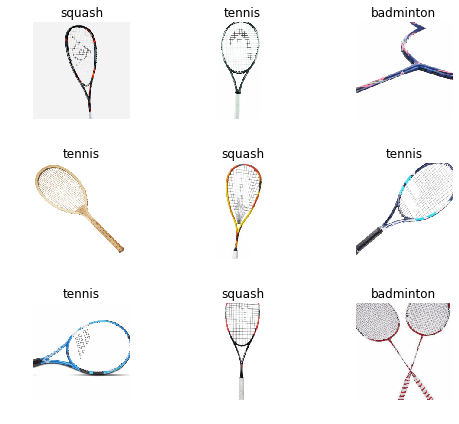

In [20]:
data.show_batch(rows=3, figsize=(7, 6))

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['badminton', 'squash', 'tennis'], 3, 458, 114)

## Train Model 

Let us train the model using the fit_one_cyle policy.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.230559,0.636016,0.254386,00:24
1,0.902337,0.396854,0.166667,00:22
2,0.730069,0.393061,0.184211,00:23
3,0.617034,0.388690,0.175439,00:23


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


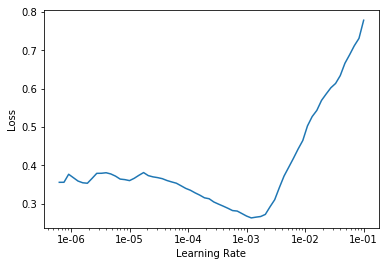

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.377971,0.329488,0.122807,00:23
1,0.326195,0.335759,0.131579,00:23


Let us save this model and take a look the confusion matrix to see which areas classes does the model get confused the most.

In [0]:
learn.save('stage-2')

In [0]:
interp  = ClassificationInterpretation.from_learner(learn)

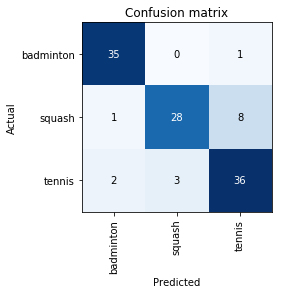

In [31]:
interp.plot_confusion_matrix()

## Exploring noisy samples

Some of the bad performance of our model is not due to our model being bad but rather due to our data being a little nosiy. We can use interp.top_losses which returns the the top losses in our dataset along with thier indices. 

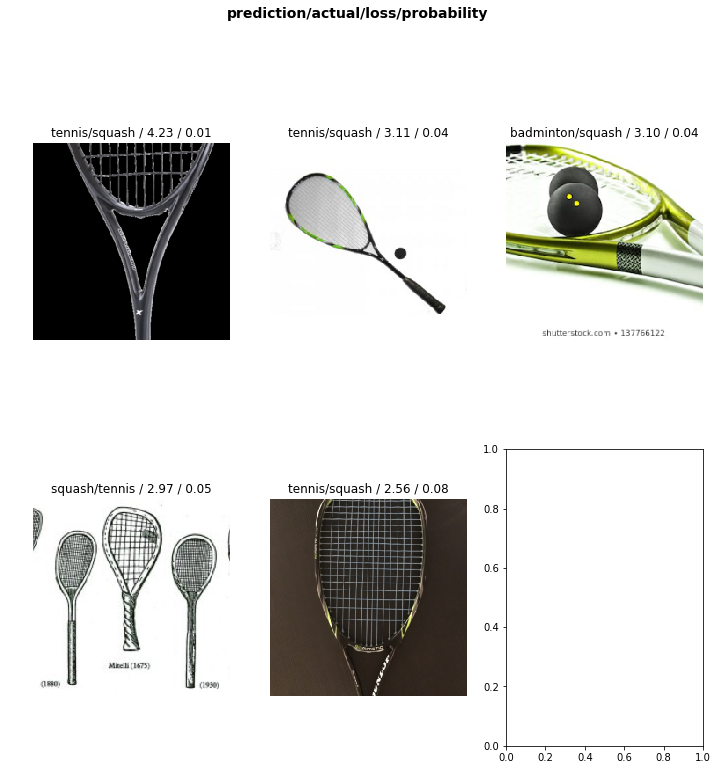

In [32]:
interp.plot_top_losses(5, heatmap=False)

Since most of the pictures aren't really all that bad we don't really have to clean them. As long as the noise is random, we are good, when the noise is biased, that bias would also reflect in the model which we must tackle. 

## Inference 






In [39]:
data.classes

['badminton', 'squash', 'tennis']

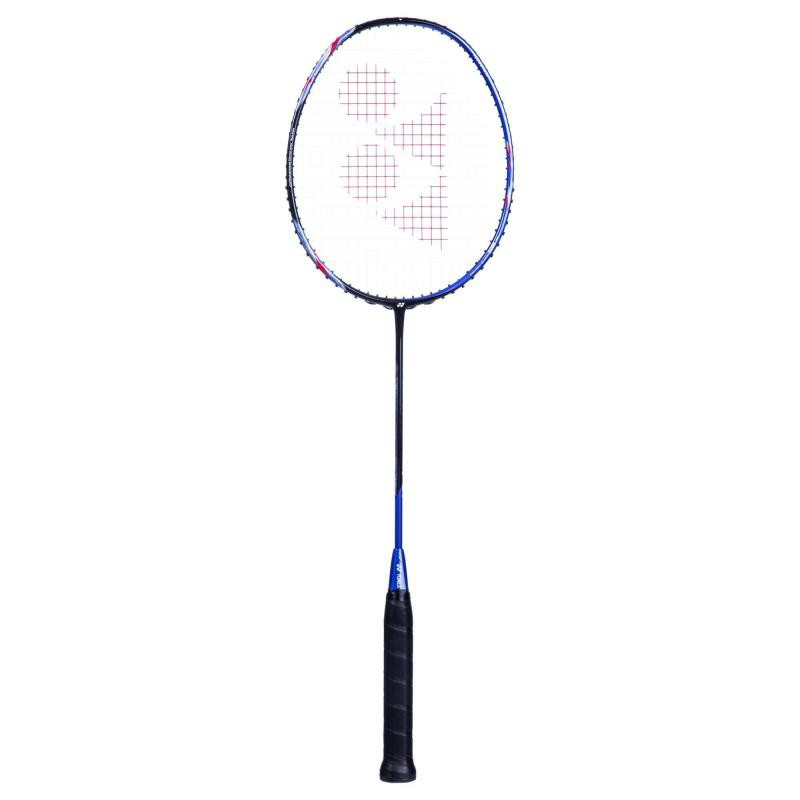

In [42]:
img = open_image(path/'badminton'/'00000007.jpg')
img

Inference is done on CPU as opposed to GPU. No training of our models is happening here, we are just giving out predictions of our dataset without any training happening.

In [0]:
# define the classes
classes = ['badminton', 'squash', 'tennis']

# create a dummy data bunch object with all the transforms, normalization that our train and validation data went through.
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
# instantiate model
learn = cnn_learner(data2, models.resnet34)
# load model 
learn.load('stage-2')

In [43]:
pred_label, pred_indx, outputs = learn.predict(img)
pred_label

Category badminton

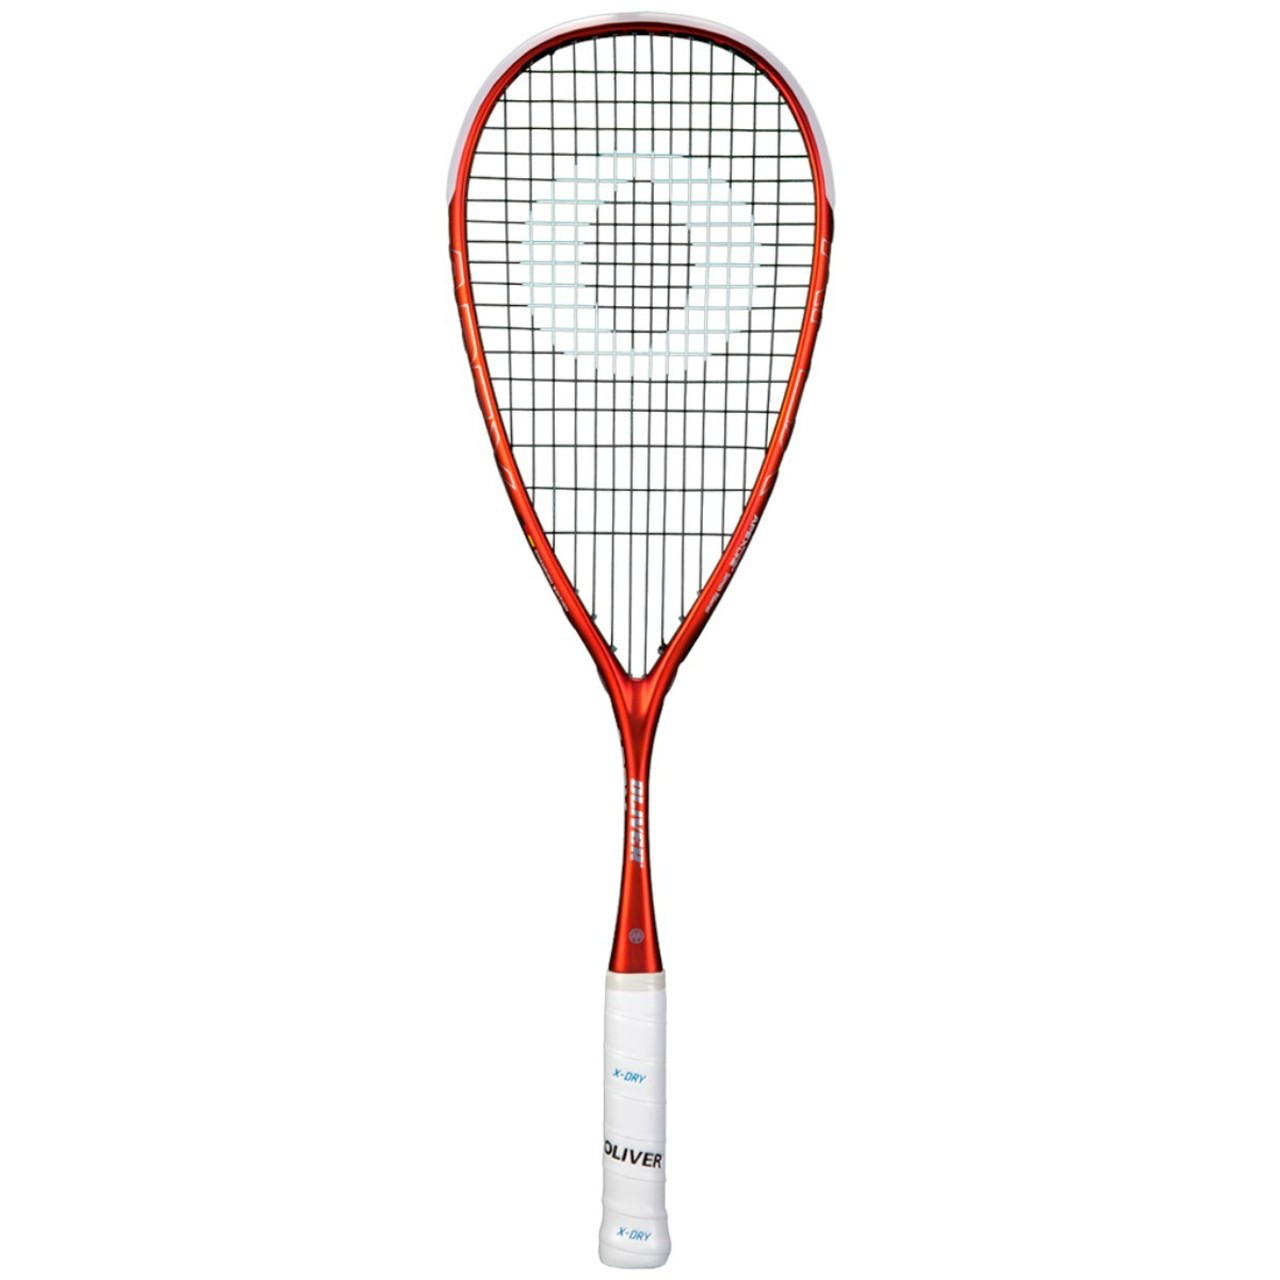

In [44]:
img2 = open_image(path/'squash'/'00000007.jpg')
img2

In [45]:
pred_label2, pred_indx2, outputs2 = learn.predict(img2)
pred_label2

Category squash

As we can see, our model is doing pretty well on all these tasks. Going further we could clean up some of the bad images and retrain our model. But this would suffice for now.